In [8]:
import pandas as pd
import torch
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt
from imblearn.over_sampling import SMOTE, SVMSMOTE,RandomOverSampler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Input, LSTM, Bidirectional, Dropout, Dense, Reshape, Embedding, Flatten
from keras import regularizers
from keras.callbacks import Callback
from sklearn.metrics import f1_score
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import LabelEncoder
import numpy as np


SymbolAlreadyExposedError: Symbol Zeros is already exposed as ().

In [32]:
path = r"C:\Users\ahmad\Downloads\ai4i2020.csv"
df = pd.read_csv(path)
data = df.copy()
data = pd.get_dummies(df, columns=['Type'])


In [33]:
look_back = 5

def create_sequences(X, y, look_back=1):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        Xs.append(X[i:(i + look_back)])
        ys.append(y[i + look_back])
    return np.array(Xs), np.array(ys)


In [73]:
# We plot features and targets, and apply minmax scaling

features_col_name = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
                     'Torque [Nm]', 'Type_H', 'Type_L', 'Type_M'] 
targets = ['TWF', 'HDF', 'PWF', 'OSF', 'Machine failure']


ok = ['Type_H', 'Type_L', 'Type_M']
scaler = MinMaxScaler()
data[ok] = scaler.fit_transform(data[ok])
data = data.drop(columns=['UDI','Product ID'], axis = 1)


data.dropna(inplace=True)

data

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Type_H,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,0.0,0.0,1.0
1,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,0.0,1.0,0.0
2,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,0.0,1.0,0.0
3,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,0.0,1.0,0.0
4,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,298.8,308.4,1604,29.5,14,0,0,0,0,0,0,0.0,0.0,1.0
9996,298.9,308.4,1632,31.8,17,0,0,0,0,0,0,1.0,0.0,0.0
9997,299.0,308.6,1645,33.4,22,0,0,0,0,0,0,0.0,0.0,1.0
9998,299.0,308.7,1408,48.5,25,0,0,0,0,0,0,1.0,0.0,0.0


In [74]:
from sklearn.utils import class_weight
X = data[features_col_name].values
y = data[targets].values

# Scaling the features
sc = MinMaxScaler()
X_scaled = sc.fit_transform(X)


y = y - np.mean(y, axis=0)
X_seq, y_seq = create_sequences(X_scaled, y, look_back=5)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=0)

# Get class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train.argmax(axis=1)), y=y_train.argmax(axis=1))
class_weights_dict = dict(enumerate(class_weights))

In [71]:
len(targets)

5

In [75]:
model = Sequential()
model.add(LSTM(units=40, return_sequences=True, input_shape=(look_back, X_train.shape[2]), dtype='float32'))
model.add(Dropout(0.4))
model.add(LSTM(units=25,activation = 'relu' ,return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(len(targets), activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 25
epochs = 120

early_stopping = EarlyStopping(monitor='val_f1_score', mode='min', patience=19, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=120, batch_size=25, verbose=1, validation_split=0.4, 
                    callbacks=[early_stopping], class_weight=class_weights_dict)

c:\Users\ahmad\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/120
192/192 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.1568 - loss: 0.4834 - val_accuracy: 0.0013 - val_loss: 0.4440
Epoch 2/120
 13/192 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0000e+00 - loss: 0.2855

c:\Users\ahmad\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_f1_score` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 2.9951e-04 - loss: 0.3811 - val_accuracy: 0.0013 - val_loss: 0.4474
Epoch 3/120
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 7.7834e-05 - loss: 0.3746 - val_accuracy: 0.0013 - val_loss: 0.4416
Epoch 4/120
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 1.2343e-04 - loss: 0.3329 - val_accuracy: 0.0013 - val_loss: 0.3699
Epoch 5/120
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 3.6725e-04 - loss: 0.3864 - val_accuracy: 0.0013 - val_loss: 0.3876
Epoch 6/120
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 1.4296e-04 - loss: 0.3620 - val_accuracy: 0.0013 - val_loss: 0.3792
Epoch 7/120
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 2.0606e-04 - loss: 0.3727 - val_accuracy: 0.0013 - val_loss: 0.4227
Epoch 8/120
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 1.6965e-04 - loss: 0.3406 - val_accuracy: 0.0013 - val_loss: 0.4175
Epoch 9/120
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 7.0037e-04 -

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


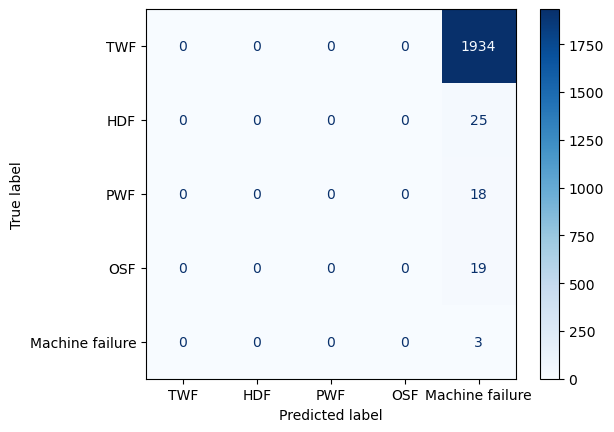

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_pred = model.predict(X_test)

# Since it's a multi-output model, we need to get the index of the max value for each prediction to get the class
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=targets)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [64]:
y_true = (y_test > 0.5).astype(int)
y_pred = (y_pred > 0.5).astype(int)

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='micro')
print("F1 Score:", f1)

F1 Score: 0.07441471571906355


In [65]:
y_pred

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]])

In [58]:
predictions1 = []
for feature_idx, target_name in enumerate(targets):
    y_pred1 = model.predict(X_test)
    y_pred_binary1 = (y_pred1 > 0.5).astype(int)
    predictions1.append(y_pred_binary1)
predictions1 = np.hstack(predictions1)


predictions1




63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [61]:
predictions1.shape

(1999, 25)

In [101]:
for target, score in best_f1_scores.items():
    print(f"{target}: {score}")


TWF: 0.927463731865933
HDF: 0.9719859929964982
PWF: 0.9874937468734367
OSF: 0.9954977488744372
Machine failure: 0.8969484742371185


array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1],
       ...,
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [103]:
np.count_nonzero(predictions)

2190

In [51]:

test_f1_scores1 = {target: 0 for target in targets}
for feature_idx, target_name in enumerate(targets):
    y_train_feature = y_train[:, feature_idx].reshape(-1, 1)
    y_train_pred = (predictions[:, feature_idx] > 0.5).astype(int)
    test_f1_scores1[target_name] = f1_score(y_train_feature, y_train_pred, average='macro') 

print("F1 Scores on the test set for each target:")
for target, score in test_f1_scores1.items():
    print(f"{target}: {score}")

F1 Scores on the test set for each target:
TWF: 0.5035535524454198
HDF: 0.4969186265878506
PWF: 0.5107981970011515
OSF: 0.567263482447125
RNF: 0.4969818913480885
Machine failure: 0.49161159125571935


In [114]:
def generate_synthetic_data(n_samples):
    np.random.seed(42)  # For reproducibility

    # Generate continuous features
    air_temp = np.random.uniform(290, 310, n_samples)  # Air temperature [K]
    process_temp = np.random.uniform(300, 320, n_samples)  # Process temperature [K]
    rotational_speed = np.random.uniform(1300, 1600, n_samples)  # Rotational speed [rpm]
    torque = np.random.uniform(30, 70, n_samples)  # Torque [Nm]``
    tool_wear = np.random.uniform(0, 250, n_samples)  # Tool wear [min]

    # Generate one-hot encoded Type features
    types = np.random.choice(['H', 'L', 'M'], n_samples)
    type_H = (types == 'H').astype(int)
    type_L = (types == 'L').astype(int)
    type_M = (types == 'M').astype(int)

    # Initialize failure modes as integer arrays
    TWF = np.zeros(n_samples, dtype=int)
    HDF = np.zeros(n_samples, dtype=int)
    PWF = np.zeros(n_samples, dtype=int)
    OSF = np.zeros(n_samples, dtype=int)
    RNF = np.zeros(n_samples, dtype=int)

    # Tool wear failure (TWF)
    twf_indices = np.random.choice(n_samples, 120, replace=False)
    twf_replace_indices = np.random.choice(twf_indices, 69, replace=False)
    twf_fail_indices = list(set(twf_indices) - set(twf_replace_indices))
    tool_wear[twf_fail_indices] = np.random.uniform(200, 240, len(twf_fail_indices))
    TWF[twf_fail_indices] = 1

    # Heat dissipation failure (HDF)
    hdf_condition = (process_temp - air_temp < 8.6) & (rotational_speed < 1380)
    hdf_indices = np.where(hdf_condition)[0]
    if len(hdf_indices) > 115:
        hdf_indices = np.random.choice(hdf_indices, 115, replace=False)
    HDF[hdf_indices] = 1

    # Power failure (PWF)
    power = torque * (rotational_speed * (2 * np.pi / 60))
    pwf_condition = (power < 3500) | (power > 9000)
    pwf_indices = np.where(pwf_condition)[0]
    if len(pwf_indices) > 95:
        pwf_indices = np.random.choice(pwf_indices, 95, replace=False)
    PWF[pwf_indices] = 1

    # Overstrain failure (OSF)
    osf_condition = ((tool_wear * torque) > 11000)
    osf_indices = np.where(osf_condition)[0]
    if len(osf_indices) > 98:
        osf_indices = np.random.choice(osf_indices, 98, replace=False)
    OSF[osf_indices] = 1

    # Random failures (RNF)
    rnf_indices = np.random.choice(n_samples, 5, replace=False)
    RNF[rnf_indices] = 1

    # Machine failure label
    machine_failure = (TWF | HDF | PWF | OSF | RNF).astype(int)

    # Create DataFrame
    data = pd.DataFrame({
        'Air temperature [K]': air_temp,
        'Process temperature [K]': process_temp,
        'Rotational speed [rpm]': rotational_speed,
        'Torque [Nm]': torque,
        'Tool wear [min]': tool_wear,
        'Type_H': type_H,
        'Type_L': type_L,
        'Type_M': type_M,
        'Machine failure': machine_failure,
        'TWF': TWF,
        'HDF': HDF,
        'PWF': PWF,
        'OSF': OSF,
        'RNF': RNF
    })

    return data

# Generate synthetic data
n_samples = 10000  # Adjust the number of samples as needed
synthetic_data = generate_synthetic_data(n_samples)

synthetic_data.to_csv(r"C:\Users\ahmad\Downloads\Simulated_Dataset.csv")

In [124]:
for lag in range(1, 6):
    synthetic_data[f'Tool wear [min]_lag_{lag}'] = data['Tool wear [min]'].shift(lag)
synthetic_data.dropna(inplace=True)


In [125]:
# Splitting the features and targets
Xs = synthetic_data[features_col_name].values
ys = synthetic_data[targets].values
scaler = MinMaxScaler()
Xs = sc.fit_transform(Xs)
Xs = Xs.reshape((Xs.shape[0], 1, Xs.shape[1]))


In [130]:

input_shape = (Xs.shape[1], Xs.shape[2])
model = mod(input_shape, 1)

# Predictions list to store predictions for each target
predictions_s = []

# Predicting without training
for feature_idx in range(ys.shape[1]):
    y_pred_s = model.predict(Xs)
    y_pred_binary_s = (y_pred_s > 0.5).astype(int)
    predictions_s.append(y_pred_binary_s)

# Convert the list of predictions to a numpy array
predictions_s = np.hstack(predictions_s)

print("Predictions shape:", predictions_s.shape)
print(predictions_s)

# Evaluating the overall model performance
for target_idx, target_name in enumerate(targets):
    print(f"Evaluation for target: {target_name}")
    y_true = ys[:, target_idx]
    y_pred = predictions_s[:, target_idx]
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"F1 Score: {f1_score(y_true, y_pred)}")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Predictions shape: (9990, 5)
[[0 0 0 0 0]
 [1 1 1 1 1]
 [1 1 1 1 1]
 ...
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
Evaluation for target: TWF
Accuracy: 0.5168168168168168
F1 Score: 0.010657921705267474
[[5137 4802]
 [  25   26]]
              precision    recall  f1-score   support

           0       1.00      0.52      0.68      9939
           1       0.01      0.51      0.01        51

    accuracy                           0.52      9990
   macro avg       0.50      0.51      0.35      9990
weighted avg       0.99      0.52      0.68      9990

Evaluation for target: HDF
Accuracy: 0.526026026026026
F1 Score: 0.04207970867893991
[[5151 4724]
 [  11  104]]
              precision    recall  f1-score   support

           0       1.00      0.52      0.69      9875
           1       0